In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta
import datetime as dt
data = pd.read_csv('./archive/btcusd.csv')
data.head(10)


,time,open,close,high,low,volume
0,1364774820000,93.25000,93.30000,93.30000,93.25000,93.300000
1,1364774880000,100.00000,100.00000,100.00000,100.00000,93.300000
2,1364774940000,93.30000,93.30000,93.30000,93.30000,33.676862
3,1364775060000,93.35000,93.47000,93.47000,93.35000,20.000000
4,1364775120000,93.47000,93.47000,93.47000,93.47000,2.021627
5,1364775180000,93.03001,93.03000,93.03001,93.03000,4.985400
6,1364775960000,93.04399,93.04399,93.04399,93.04399,12.689501
7,1364776080000,93.34999,93.35000,93.35000,93.34999,5.000000
8,1364776500000,93.19999,93.35000,93.35000,93.19999,40.000000
9,1364777580000,93.25000,93.30000,93.30000,93.25000,18.300000


In [16]:
# Adding indicators
data['time'] = pd.to_datetime(data['time'],unit='ms')
#resample data to 1 day
data = data.resample('1D', on='time').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume': 'sum'})
data['RSI']=ta.rsi(data.close, length=15)
data['EMAF']=ta.ema(data.close, length=20)
data['EMAM']=ta.ema(data.close, length=100)
data['EMAS']=ta.ema(data.close, length=150)
data['Target'] = data['close']-data.open
data['Target'] = data['Target'].shift(-1)
#only read first 10 characters from time column
data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))]
data['TargetNextClose'] = data['close'].shift(-1)

data.dropna(inplace=True)
data.reset_index(inplace = True)
data.drop(['high', 'low','open','time'],axis = 1, inplace=True)

In [18]:

data_set = data.iloc[:,0:10]#.values
pd.set_option('display.max_columns', None)


print(data_set.shape)
print(data.shape)
print(type(data_set))

(3355, 9)
(3355, 9)
<class 'pandas.core.frame.DataFrame'>


In [10]:
data

,close,volume,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose
0,118.00,3508.161705,77.173923,105.932221,104.128446,107.943196,0.55,1,118.50
1,118.50,2722.033721,77.584574,107.129152,104.413031,108.083021,6.07,1,125.00
2,125.00,9634.039484,82.075995,108.831138,104.820694,108.307087,2.91,1,127.80
3,127.80,12537.834201,83.593278,110.637696,105.275729,108.565271,2.20,1,130.41
4,130.41,2117.607623,84.872224,112.520772,105.773438,108.854605,-1.28,0,129.45
...,...,...,...,...,...,...,...,...,...
3350,27714.00,2701.677011,69.603903,24490.853201,21981.477542,21687.427935,399.00,1,28112.00
3351,28112.00,1662.375429,70.833404,24835.724325,22102.874027,21772.521605,-853.00,0,27258.00
3352,27258.00,3933.619033,64.806836,25066.417246,22204.955729,21845.176948,1046.00,1,28304.00
3353,28304.00,3122.927476,68.341582,25374.758461,22325.728883,21930.724273,-847.00,0,27461.00


In [19]:

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled = sc.fit_transform(data_set)
print(data_set_scaled)

[[2.09871682e-04 1.19092230e-02 7.58273728e-01 ... 4.83037536e-01
  1.00000000e+00 2.17287642e-04]
 [2.17287642e-04 9.04252736e-03 7.62770913e-01 ... 4.83412893e-01
  1.00000000e+00 3.13695128e-04]
 [3.13695128e-04 3.42478595e-02 8.11958000e-01 ... 4.83198014e-01
  1.00000000e+00 3.55224507e-04]
 ...
 [4.02748207e-01 1.34606965e-02 6.22837525e-01 ... 5.54127567e-01
  1.00000000e+00 4.18262396e-01]
 [4.18262396e-01 1.05044272e-02 6.61547741e-01 ... 4.25404597e-01
  0.00000000e+00 4.05759087e-01]
 [4.05759087e-01 6.11117124e-03 6.01818006e-01 ... 4.86876105e-01
  1.00000000e+00 4.06634170e-01]]


In [33]:
# multiple feature from data provided to the model
X = []

backcandles = 30
print(data_set_scaled.shape[0])
for j in range(6):#data_set_scaled[0].size):#2 columns are target not X
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):#backcandles+2
        X[j].append(data_set_scaled[i-backcandles:i, j])

#move axis from 0 to position 2
X=np.moveaxis(X, [0], [2])

#Erase first elements of y because of backcandles to match X length
#del(yi[0:backcandles])
#X, yi = np.array(X), np.array(yi)
# Choose -1 for last column, classification else -2...
X, yi =np.array(X), np.array(data_set_scaled[backcandles:,-3])
y=np.reshape(yi,(len(yi),1))
#y=sc.fit_transform(yi)
#X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X)
print(X.shape)
print(y)
print(y.shape)

3355
[[[2.09871682e-04 1.19092230e-02 7.58273728e-01 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [2.17287642e-04 9.04252736e-03 7.62770913e-01 1.89805968e-05
   5.18287706e-06 2.67655770e-06]
  [3.13695128e-04 3.42478595e-02 8.11958000e-01 4.59701986e-05
   1.26072466e-05 6.96566541e-06]
  ...
  [3.00198080e-04 1.06595765e-02 5.36867725e-01 2.69713120e-04
   1.52500999e-04 9.40733003e-05]
  [2.95155227e-04 6.04617920e-03 5.27698807e-01 2.70935611e-04
   1.56557385e-04 9.68349318e-05]
  [3.13991767e-04 2.77106795e-03 5.54398590e-01 2.73959702e-04
   1.60991452e-04 9.98819795e-05]]

 [[2.17287642e-04 9.04252736e-03 7.62770913e-01 1.89805968e-05
   5.18287706e-06 2.67655770e-06]
  [3.13695128e-04 3.42478595e-02 8.11958000e-01 4.59701986e-05
   1.26072466e-05 6.96566541e-06]
  [3.55224507e-04 4.48368424e-02 8.28574282e-01 7.46180862e-05
   2.08943752e-05 1.19078719e-05]
  ...
  [2.95155227e-04 6.04617920e-03 5.27698807e-01 2.70935611e-04
   1.56557385e-04 9.68349318e-05]
  [3.139917

In [34]:
#also comprehensions for X
#X = np.array([data_set_scaled[i-backcandles:i,:4].copy() for i in range(backcandles,len(data_set_scaled))])
#print(X)
#print(X.shape)

In [35]:
# split data into train test sets
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

2660
(2660, 30, 6)
(665, 30, 6)
(2660, 1)
(665, 1)
[[0.48302938]
 [0.48299266]
 [0.48292874]
 ...
 [0.43091255]
 [0.28743124]
 [0.40909353]]


In [36]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np

lstm_input = Input(shape=(backcandles, 6), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('sigmoid', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
160/160 [==============================] - 4s 17ms/step - loss: 3.7924e-04 - val_loss: 0.0130
Epoch 2/30
160/160 [==============================] - 2s 15ms/step - loss: 3.6576e-04 - val_loss: 0.0133
Epoch 3/30
160/160 [==============================] - 2s 15ms/step - loss: 3.5382e-04 - val_loss: 0.0134
Epoch 4/30
160/160 [==============================] - 2s 15ms/step - loss: 3.5607e-04 - val_loss: 0.0131
Epoch 5/30
160/160 [==============================] - 2s 15ms/step - loss: 3.5328e-04 - val_loss: 0.0135
Epoch 6/30
160/160 [==============================] - 4s 27ms/step - loss: 3.5641e-04 - val_loss: 0.0132
Epoch 7/30
160/160 [==============================] - 2s 15ms/step - loss: 3.5309e-04 - val_loss: 0.0135
Epoch 8/30
160/160 [==============================] - 2s 15ms/step - loss: 3.5443e-04 - val_loss: 0.0130
Epoch 9/30
160/160 [==============================] - 2s 15ms/step - loss: 3.5361e-04 - val_loss: 0.0131
Epoch 10/30
160/160 [==============================] - 

In [37]:
y_pred = model.predict(X_test)
#y_pred=np.where(y_pred > 0.43, 1,0)
for i in range(10):
    print(y_pred[i], y_test[i])

21/21 [==============================] - 0s 7ms/step
[0.44102573] [0.55280851]
[0.44004247] [0.59662723]
[0.43904987] [0.44173746]
[0.43801114] [0.54447164]
[0.43699908] [0.59476602]
[0.43628716] [0.32105844]
[0.43568474] [0.39398885]
[0.43538058] [0.49918401]
[0.43555844] [0.33278934]
[0.43603426] [0.47144023]


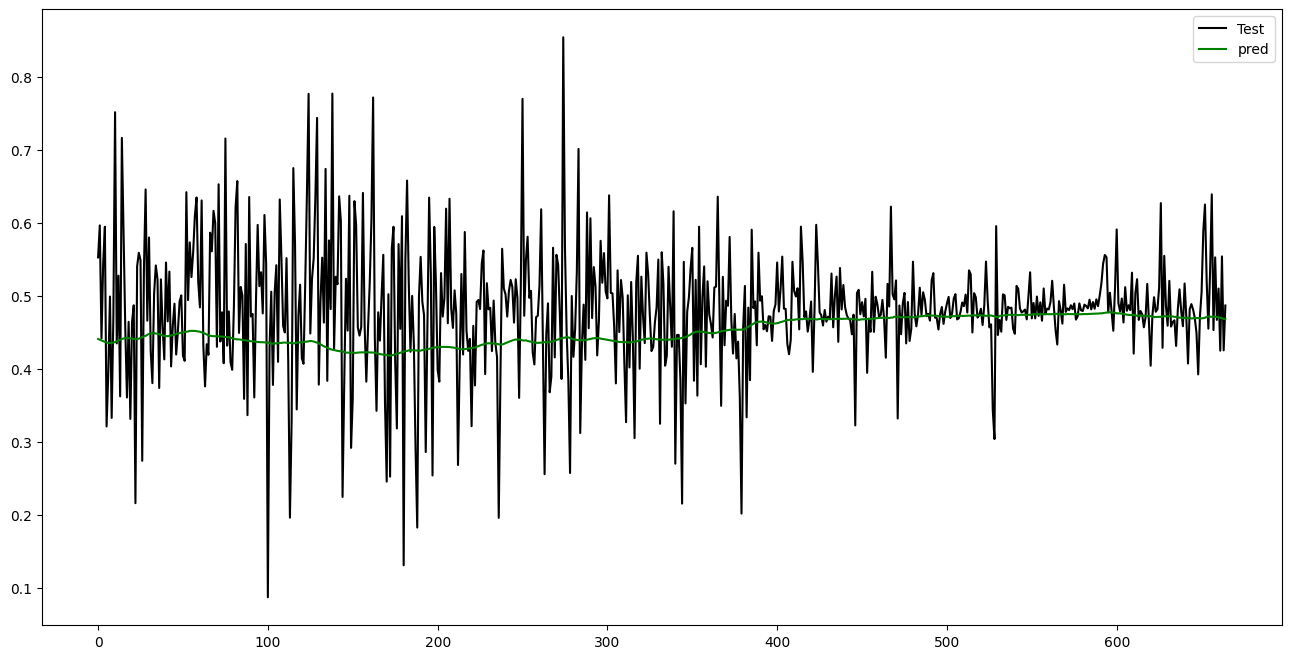

In [38]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.legend()
plt.show()